In [3]:
%matplotlib inline
import seaborn as sns
import math
import datetime
import matplotlib.pyplot as plt
import operator
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_summary import DataFrameSummary
from isoweek import Week
from tqdm import tqdm
pd.options.display.max_columns = 50
from sklearn.externals import joblib

In [8]:
from keras.models import load_model
from keras.layers import Input, Dense, \
BatchNormalization, Dropout, Activation
from keras.models import Model

from sklearn.model_selection import train_test_split, \
GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
saleprice = df_train['SalePrice'].values
df_all = df_all.drop(['SalePrice'], axis=1)

n_train = df_train.shape[0]
n_test = df_test.shape[0]

print df_train.shape
print df_test.shape
print df_all.shape

(1460, 81)
(1459, 80)
(2919, 80)


## Data Exploration

In this task, we need to build statistical model to predict the final price of houses. The dataset contains numerous features about the house, including the total size within each area of the house, the description about the location and the condition of different properties of the house. We will combine our train and test dataset into `df_all`, which we will use to perform Data Cleaning and Feature Engineering

In [10]:
train_dfs = DataFrameSummary(df_train)
dfs = DataFrameSummary(df_all)
dfs_summary = dfs.summary()
display(dfs_summary)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,...,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919,2919,2919,NaN,2919,NaN,NaN,NaN,2918,2918,NaN,NaN,2917,2917,NaN,2918,NaN,NaN,NaN,NaN,2919,NaN,NaN,NaN,NaN,...,2896,NaN,NaN,2919,2919,NaN,2919,2919,2919,NaN,2919,NaN,NaN,NaN,NaN,NaN,2919,NaN,2919,2918,NaN,2919,2919,2919,2919
mean,1159.58,336.484,2.60226,NaN,2.86023,NaN,NaN,NaN,441.423,49.5822,NaN,NaN,0.429894,0.0613644,NaN,560.772,NaN,NaN,NaN,NaN,23.0983,NaN,NaN,NaN,NaN,...,102.201,NaN,NaN,50.826,6.21309,NaN,47.4868,5.56458,6.08907,NaN,2.2518,NaN,NaN,NaN,NaN,NaN,16.0624,NaN,6.45152,1051.78,NaN,93.7098,1971.31,1984.26,2007.79
std,392.362,428.701,25.1882,NaN,0.822693,NaN,NaN,NaN,455.611,169.206,NaN,NaN,0.524736,0.245687,NaN,439.544,NaN,NaN,NaN,NaN,64.2442,NaN,NaN,NaN,NaN,...,179.334,NaN,NaN,567.402,2.71476,NaN,67.5755,1.11313,1.40995,NaN,35.6639,NaN,NaN,NaN,NaN,NaN,56.1844,NaN,1.56938,440.766,NaN,126.527,30.2914,20.8943,1.31496
min,334,0,0,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0,1,NaN,0,1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,2,0,NaN,0,1872,1950,2006
25%,876,0,0,NaN,2,NaN,NaN,NaN,0,0,NaN,NaN,0,0,NaN,220,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0,4,NaN,0,5,5,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,5,793,NaN,0,1953.5,1965,2007
50%,1082,0,0,NaN,3,NaN,NaN,NaN,368.5,0,NaN,NaN,0,0,NaN,467,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,0,NaN,NaN,0,6,NaN,26,5,6,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,6,989.5,NaN,0,1973,1993,2008
75%,1387.5,704,0,NaN,3,NaN,NaN,NaN,733,0,NaN,NaN,1,0,NaN,805.5,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,164,NaN,NaN,0,8,NaN,70,6,7,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,7,1302,NaN,168,2001,2004,2009
max,5095,2065,508,NaN,8,NaN,NaN,NaN,5644,1526,NaN,NaN,3,2,NaN,2336,NaN,NaN,NaN,NaN,1012,NaN,NaN,NaN,NaN,...,1600,NaN,NaN,17000,12,NaN,742,9,10,NaN,800,NaN,NaN,NaN,NaN,NaN,576,NaN,15,6110,NaN,1424,2010,2010,2010
counts,2919,2919,2919,198,2919,2919,2837,2837,2918,2918,2840,2839,2917,2917,2838,2918,2919,2919,2919,2918,2919,2919,2919,2918,2918,...,2896,2895,105,2919,2919,2919,2919,2919,2919,2919,2919,10,2919,2919,2919,2918,2919,2919,2919,2918,2917,2919,2919,2919,2919
uniques,1083,635,31,2,8,5,4,4,991,272,6,6,4,3,4,1135,2,9,8,5,183,5,4,15,16,...,444,4,4,38,12,25,252,9,10,3,14,3,8,6,6,9,121,2,14,1058,2,379,118,61,5


The first thing that we can observe from the description of the dataset is that there are a lot of missing values in different columns. Luckily, it is expected as the NA value can mean different things as explained in the `data_description.txt`. However, there are still true missing values, and we will just use the median/mode from all observations to replace those true missing values

In [11]:
df_missing_perc = dfs_summary.loc['missing_perc', :]
df_missing_perc.sort_values(ascending = False, inplace=True)
df_missing_perc[df_missing_perc.values != '0%']

PoolQC          99.66%
MiscFeature     96.40%
Alley           93.22%
Fence           80.44%
GarageCond       5.45%
GarageFinish     5.45%
GarageQual       5.45%
GarageYrBlt      5.45%
GarageType       5.38%
FireplaceQu     48.65%
BsmtCond         2.81%
BsmtExposure     2.81%
BsmtQual         2.77%
BsmtFinType2     2.74%
BsmtFinType1     2.71%
LotFrontage     16.65%
MasVnrType       0.82%
MasVnrArea       0.79%
MSZoning         0.14%
BsmtFullBath     0.07%
BsmtHalfBath     0.07%
Functional       0.07%
Utilities        0.07%
Electrical       0.03%
Exterior2nd      0.03%
KitchenQual      0.03%
Exterior1st      0.03%
GarageCars       0.03%
TotalBsmtSF      0.03%
GarageArea       0.03%
BsmtUnfSF        0.03%
BsmtFinSF2       0.03%
BsmtFinSF1       0.03%
SaleType         0.03%
Name: missing_perc, dtype: object

Looking at the plot of the `SalePrice`, it is highly skewed. In one of our model, we will use Linear Model to predict the sales value. Therefore, it will be a good idea for us to transform the data by taking the log of the values so that the distribution of the values is more normally distributed.

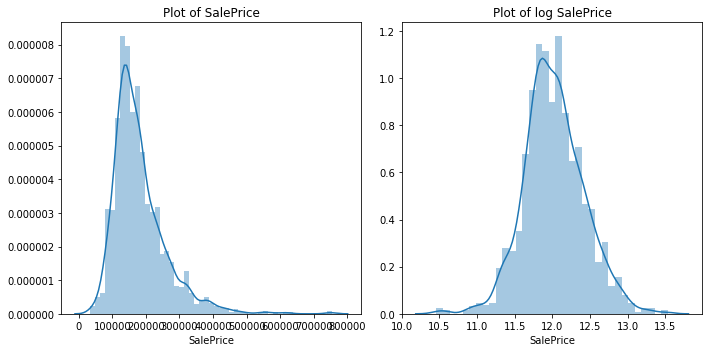

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.distplot(df_train['SalePrice'],
             ax = axes[0]).set_title('Plot of SalePrice')
sns.distplot(np.log(df_train['SalePrice']),
             ax = axes[1]).set_title('Plot of log SalePrice')
plt.tight_layout()
plt.show()

Looking at some of the `data_description.txt`, it seems that some of the categorical data actually contains ordinal information. Therefore, it will be a good idea for us to transform those data into real values. Even though it might not be a good idea for our Linear Model, it will be a good idea for our tree ensemble models as we are able to leverage on the ordinal information as we are able to build decision tree that seperates the observation based on the Quality.

In [13]:
def replace_1(df_column):
    return df_column.\
replace({"No" : 0, "Po" : 1, "Fa" : 2,
         "TA" : 3, "Gd" : 4, "Ex" : 5})

def replace_2(df_column):
    return df_column.\
replace({"No" : 0, "Unf" : 1,
         "LwQ": 2, "Rec" : 3,
         "BLQ" : 4, 
         "ALQ" : 5, "GLQ" : 6})

def replace_3(df_column):
    return df_column.\
replace({"No" : 0, "Mn" : 1, 
         "Av": 2, "Gd" : 3})

def replace_4(df_column):
    return df_column.\
replace({"Sal" : 1, "Sev" : 2,
         "Maj2" : 3, "Maj1" : 4, 
         "Mod": 5, 
         "Min2" : 6, "Min1" : 7,
         "Typ" : 8})


In `handle_missing_data` we perform multiple tasks

- Missing Value
    
    - Most of the missing value is due to the absence of it (house with NA value in the `Alley` column is due to the house not having an alley). Therefore, we can savely change it to No / 0, depending on the column being a categorical/numerical data
    - The data on `MSZoning`, `SaleType`, `Electrical`, `Exterior1st`, `Exterior2nd` is truly missing. Thus, we will fill it up using the mode of those values.
        
- Categorical -> Numeric, Numeric -> Categorical
    
    - The Month and Year where the House is sold should be a categorical Variable. The classification of zoning of the house `MSZoning` should also be categorical Variable
    - Most of the categorical variable indicating the Condition of house property, such as `BasementCond` and `GarageCond` have ordinal data such as "Good", "Fair", or "Poor". we will transform this using the dictionary above

In [14]:
def handle_missing_data(df):    
    df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtFinSF1"] = df.loc[:, "BsmtFinSF1"].fillna(0)
    df.loc[:, "BsmtFinSF2"] = df.loc[:, "BsmtFinSF2"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
    df.loc[:, "TotalBsmtSF"] = df.loc[:, "TotalBsmtSF"].fillna(0)
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
    df.loc[:, "GarageYrBlt"] = df.loc[:, "GarageYrBlt"].fillna(0)
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    
    

    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

   
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    df['Utilities'] = np.where(df['Utilities'].values == 'AllPub', 0,1)
    df['CentralAir'] = np.where(df['CentralAir'].values == 'N', 0,1)
    df['Street'] = np.where(df['Street'].values == 'Grvl', 0,1)
    
    df['BsmtCond'] = replace_1(df['BsmtCond'])
    df['BsmtExposure'] = replace_3(df['BsmtExposure'])
    df['BsmtFinType1'] = replace_2(df['BsmtFinType1'])
    df['BsmtFinType2'] = replace_2(df['BsmtFinType2'])
    df['BsmtQual'] = replace_1(df['BsmtQual'])
    df['ExterCond'] = replace_1(df['ExterCond'])
    df['ExterQual'] = replace_1(df['ExterQual'])
    df['FireplaceQu'] = replace_1(df['FireplaceQu'])
    df['Functional'] = replace_4(df['Functional'])
    df['GarageCond'] = replace_1(df['GarageCond'])
    df['GarageQual'] = replace_1(df['GarageQual'])
    df['HeatingQC'] = replace_1(df['HeatingQC'])
    df['KitchenQual'] = replace_1(df['KitchenQual'])
    df['PoolQC'] = replace_1(df['PoolQC'])
    
    df['isBasement'] = df['TotalBsmtSF'] > 0.
    df['TotalSquareFloor'] = df['TotalBsmtSF'] + df['GrLivArea']
    df['TotalProch'] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
                        df["3SsnPorch"] + df["ScreenPorch"]
    df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
                        df["FullBath"] + (0.5 * df["HalfBath"])
    
    return df

In [15]:
df_all_complete = handle_missing_data(df_all)

We will then perform one-hot encoding to all categorical variable. We will also split the merged dataset, `df_all`, back to train and test dataset.

In [ ]:
cat_features = dfs_summary.\
columns[(dfs_summary.loc['types', :] == \
         'categorical').values].tolist()
df_all_dummy = \
pd.get_dummies(df_all_complete,
               columns=cat_features, prefix=cat_features)
df_all_dummy = df_all_dummy.drop('Id', axis = 1)
X_full_train = df_all_dummy[:n_train].values.astype(float)
X_test = df_all_dummy[n_train:].values.astype(float)
Y_full_train = np.log(saleprice.astype(float))
X_train, X_val, Y_train, Y_val = \
train_test_split(X_full_train, Y_full_train, test_size=0.2)

In [91]:
print X_full_train.shape
print Y_full_train.shape
print X_train.shape
print Y_train.shape
print X_val.shape
print Y_val.shape
print X_test.shape

(1460, 271)
(1460,)
(1168, 271)
(1168,)
(292, 271)
(292,)
(1459, 271)


## Model



There are two stacks of models in predicting the sale price of the houses

For the First stack in this Model. we will train three different predictions. The model takes in all the features that we have engineered (271 features) as an input, we will train them by fitting them against the true Sale price value of the houses. The three models that we use in the first stack are:

- Cross-Validated Elastic Net. Elastic Net is a linear model with L1 Norm and L2 Norm Regularization
- Random Forest Regressor 
- Gradient Boosting Regressor

In [137]:
from sklearn.linear_model import LinearRegression,
LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, 
GradientBoostingRegressor
import xgboost as xgb
from keras.models import load_model
from keras.layers import Input, Dense, 
BatchNormalization, Dropout, Activation
from keras.models import Model
from keras import backend as K
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

In [100]:
from sklearn.metrics import mean_squared_error

In [94]:
kfold = KFold(n_splits = 5, shuffle = True, random_state=1234)

We measure the performance of the model by performing 5-Fold Cross Validation across the training dataset. For each fold, we will train the model on the rest of the folds and calculate the negative mean squared error between the predicted log Sale Price value of the fold and the ground truth. We will then take the mean and the standard deviation of the error values within all folds. As we can see below, each model perform comparably well. The best prediction came from the Gradient Boosting Regressor model

In [138]:
enet_model = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001,
                                  0.01, 0.1, 1, 10], 
                          l1_ratio=[.01, .1, .5, .9, 
                                    .99], max_iter=5000)\
.fit(X_train, Y_train)
enet_score = cross_val_score(enet_model, X_full_train, 
                             Y_full_train, scoring = 'neg_mean_squared_error', 
                             cv = kfold.split(X_full_train), n_jobs=-1)
print np.mean(enet_score), np.std(enet_score)

-0.01972729133615338 0.006881608679943028


In [142]:
rf_model = RandomForestRegressor(n_estimators=5000,
                                   max_depth=10,
                                 max_features='sqrt')
rf_score = cross_val_score(rf_model, X_full_train,
                           Y_full_train,
                           scoring = 'neg_mean_squared_error',
                           cv = kfold.split(X_full_train), 
                           n_jobs=-1)
print np.mean(rf_score), np.std(rf_score)

-0.02088691421120832 0.0035739920647648595


In [140]:
gb_model = \
GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gb_score = cross_val_score(gb_model, X_full_train, 
                           Y_full_train, scoring = 'neg_mean_squared_error', 
                           cv = kfold.split(X_full_train), n_jobs=-1)
print np.mean(gb_score), np.std(gb_score)


-0.015993209908324264 0.0028091448362989172



We will then use the prediction from these three values as an input for our model in the second stack. For each observation, this model takes in value from the three predictions as the features. We will also fit this model against the true Sale Price value of the houses. I have build two model to perform this, but in reality we need to choosd one of them. The models that I use in the second stack are:

- Neural Network (2 hidden layer with Node (3, 3))
- ElasticNetCV

In [177]:
enet_pred_train = enet_model.fit(X_full_train, Y_full_train).predict(X_full_train)
rf_pred_train = rf_model.fit(X_full_train, Y_full_train).predict(X_full_train)
gb_pred_train = gb_model.fit(X_full_train, Y_full_train).predict(X_full_train)

In [202]:
enet_pred_train = enet_pred_train.reshape(-1)
rf_pred_train = rf_pred_train.reshape(-1)
gb_pred_train = gb_pred_train.reshape(-1)

In [203]:
print enet_pred_train.shape
print rf_pred_train.shape
print gb_pred_train.shape

(1460,)
(1460,)
(1460,)


In [209]:
all_pred_train = np.zeros((1460,3))
all_pred_train[:,0]=enet_pred_train
all_pred_train[:,1]=rf_pred_train
all_pred_train[:,2]=gb_pred_train

In [213]:
inputs = Input(shape = (all_pred.shape[1],), name='Input')
X = Dense(3, name='Dense1', activation='relu')(inputs)
X = BatchNormalization(name='BN1')(X)
X = Dense(3, name='Dense2', activation='relu')(X)
X = BatchNormalization(name='BN2')(X)
outputs = Dense(1, name='Dense3', activation='relu')(X)

NN_model = Model(inputs=inputs, outputs=outputs, name='NN_Model')
NN_model.compile('adam', 'mean_squared_error')
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3)                 0         
_________________________________________________________________
Dense1 (Dense)               (None, 3)                 12        
_________________________________________________________________
BN1 (BatchNormalization)     (None, 3)                 12        
_________________________________________________________________
Dense2 (Dense)               (None, 3)                 12        
_________________________________________________________________
BN2 (BatchNormalization)     (None, 3)                 12        
_________________________________________________________________
Dense3 (Dense)               (None, 1)                 4         
Total params: 52
Trainable params: 40
Non-trainable params: 12
_________________________________________________________________


In [ ]:
NN_model.fit(all_pred_train, Y_full_train, epochs=80, 
             batch_size=64, validation_split= 0.0)

In [ ]:
enet2_model = ElasticNetCV(alphas=[0.0001, 0.0005,
                                   0.001, 0.01, 0.1, 1, 10], 
                           l1_ratio=[.01, .1, .5, .9, .99], 
                           max_iter=5000).fit(all_pred_train, 
                                              Y_full_train)

## Prediction

In [215]:
enet_pred = enet_model.fit(X_full_train, Y_full_train).predict(X_test)
rf_pred = rf_model.fit(X_full_train, Y_full_train).predict(X_test)
gb_pred = gb_model.fit(X_full_train, Y_full_train).predict(X_test)
all_pred = np.zeros((1459, 3))
all_pred[:, 0] = enet_pred
all_pred[:, 0] = rf_pred
all_pred[:, 0] = gb_pred

sales_value = NN_model.predict(all_pred, batch_size = 64)

In [210]:
enet2_model.predict(all_pred)

In [216]:
result = {
    "Id" : df_test.Id.tolist(),
    "SalePrice" : np.exp(sales_value).reshape(-1).tolist()
}

df_result = pd.DataFrame(result)

In [217]:
df_result.to_csv("entry5.csv", index=False)

Upon submitting the result to Kaggle, the result of this prediction in the public score are 0.12196 and 0.13177 respectively